# 다항분류

> 아이리스 데이터 셋

## #01. 준비작업

### [1] 패키지 가져오기

In [9]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.tensor import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터 가져오기


In [10]:
origin = my_read_excel(
    path="https://data.hossam.kr/mldata/iris.xlsx", categories=["Species"]
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Sepal.Length  150 non-null    float64 
 1   Sepal.Width   150 non-null    float64 
 2   Petal.Length  150 non-null    float64 
 3   Petal.Width   150 non-null    float64 
 4   Species       150 non-null    category
dtypes: category(1), float64(4)
memory usage: 5.1 KB
None

상위 5개 행
+----+----------------+---------------+----------------+---------------+-----------+
|    |   Sepal.Length |   Sepal.Width |   Petal.Length |   Petal.Width | Species   |
|----+----------------+---------------+----------------+---------------+-----------|
|  0 |            5.1 |           3.5 |            1.4 |           0.2 | setosa    |
|  1 |            4.9 |             3 |            1.4 |           0.2 | setosa    |
|  2 |            4.7 |           3.2 |            1.3 |           0.2 | setosa    |
|  3 |     

## #02. 데이터 전처리

### [1] 독립변수 표준화

In [11]:
df = my_standard_scaler(origin, yname="Species")
my_pretty_table(df.head())

+----+----------------+---------------+----------------+---------------+-----------+
|    |   Sepal.Length |   Sepal.Width |   Petal.Length |   Petal.Width | Species   |
|----+----------------+---------------+----------------+---------------+-----------|
|  0 |      -0.900681 |         1.019 |       -1.34023 |      -1.31544 | setosa    |
|  1 |       -1.14302 |     -0.131979 |       -1.34023 |      -1.31544 | setosa    |
|  2 |       -1.38535 |      0.328414 |       -1.39706 |      -1.31544 | setosa    |
|  3 |       -1.50652 |     0.0982173 |       -1.28339 |      -1.31544 | setosa    |
|  4 |       -1.02185 |        1.2492 |       -1.34023 |      -1.31544 | setosa    |
+----+----------------+---------------+----------------+---------------+-----------+


### [2] 종속변수 라벨링

여기서는 데이터 타입을 `int` 로 변경하는 것을 목적으로 한다.


In [12]:
df2 = my_labelling(df, "Species")

+------------+---------+
| Species    |   label |
|------------+---------|
| setosa     |       0 |
| versicolor |       1 |
| virginica  |       2 |
+------------+---------+


### [3] 독립, 종속 변수 분리

In [13]:
x = df2.drop(["Species"], axis=1)
y = df2["Species"]
x.shape, y.shape

((150, 4), (150,))

### [4] 종속변수에 대한 `to_categorical()` 함수 적용

> Tensorflow에서만 필요한 처리

one-hot-encoding 처리를 수행한다.

머신러닝에서 더미변수 처리와 같은 원리

In [14]:
y_cate = to_categorical(y)
y_cate[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

### [3] 훈련, 검증 데이터 분리


In [15]:
x_train, x_test, y_train, y_test = my_train_test_split(data=x, ydata=y_cate)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120, 3), (30, 3))

## #03. 훈련 모델 적합

### [1] 모델 구성

| 구분 | 모델 | 활성화 함수 | 옵티마이저 | 손실함수 | 평가지표 | 대표예제 |
|--|--|--|--|--|--|--|
| 분류 | 다항분류 | [relu, ...] softmax | adam 혹은 rmsprop | categorical_crossentropy | acc | iris 분류 |


In [16]:
cols = x_train.shape[1]
cols

4

In [17]:
classes = len(y_cate[0])
classes

3

In [18]:
model = Sequential()
model.add(Dense(64, activation="relu", input_shape=(cols,)))
model.add(Dense(classes, activation="softmax"))
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 515 (2.01 KB)

 Trainable params: 515 (2.01 KB)

 Non-trainable params: 0 (0.00 B)

### [2] 모델 학습

In [19]:
result = model.fit(
    x_train,
    y_train,
    epochs=500,
    validation_data=(x_test, y_test),
    verbose=0,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10, verbose=0),
        ReduceLROnPlateau(monitor="val_loss", patience=5, min_lr=0.0001, verbose=0),
    ],
)

In [20]:
ev = model.evaluate(x_test, y_test)
print("손실률: %0.2f%%, 정확도: %0.2f%%" % (ev[0], ev[1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - acc: 1.0000 - loss: 0.0125
손실률: 0.01%, 정확도: 1.00%


### [3] 학습 곡선 확인

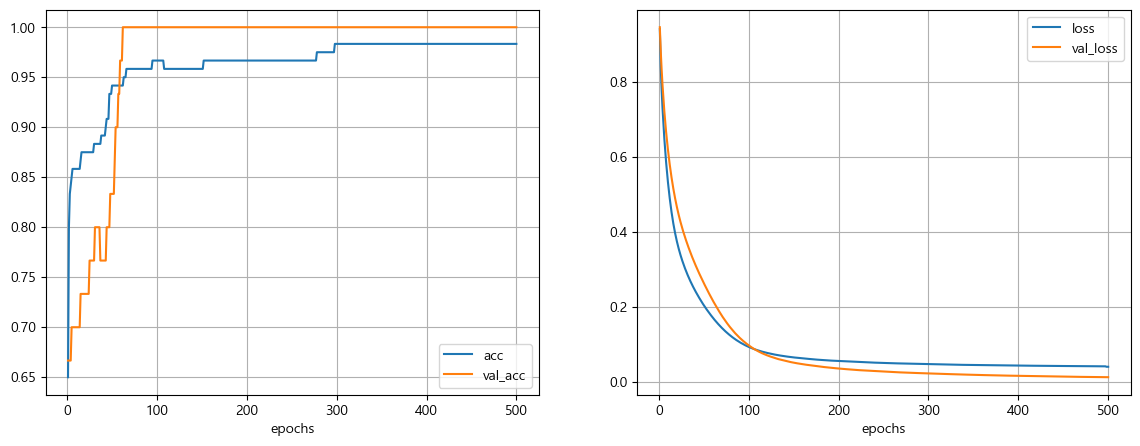

In [21]:
tf_result(result=result)